In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, embed_signal, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Functions

In [3]:
def perform_VAR_p_analysis(data, windows, max_lag, T_pred=25, num_window_samples=5):
    lags = np.arange(1, max_lag + 1)
    
    grid_search_df = []
    iterator = tqdm(total = len(windows)*len(lags))
    for window in windows:
        stride = window
        min_ind = int(0/stride)
        max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
        possible_inds = np.arange(min_ind, max_ind + 1)
        window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
    #     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
        for p in lags:
    #         for i in range(num_windows):
            for i in window_inds:
                start_ind = i*int(stride/dt)
                start_time = i*stride
                end_ind = i*int(stride/dt) + int(window/dt)
                end_time = i*stride + window
                if end_ind + T_pred <= data.shape[0]:

                    window_data = data[start_ind:end_ind]
                    results = compute_VAR_p(window_data, p)
                    test_data = data[end_ind - p:end_ind + T_pred]

                    train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                    train_mse = ((train_prediction - train_true_vals)**2).mean()
                    test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
                    test_mse = ((test_prediction - test_true_vals)**2).mean()
                    persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                    # ADD TO DICTIONARY
                    results['train_mse'] = train_mse
                    results['test_mse'] = test_mse
                    results['persistence_baseline'] = persistence_baseline

                    # ADD TIMESTAMPS
                    results['start_ind'] = start_ind
                    results['end_ind'] = end_ind
                    results['start_time'] = start_time
                    results['end_time'] = end_time

                    # ADD PARAMETERS
                    results['window'] = window
                    results['stride'] = stride
                    results['p'] = p
                    results['T_pred'] = T_pred

                    grid_search_df.append(results)
            iterator.update()
    iterator.close()
    grid_search_df = pd.DataFrame(grid_search_df)
    
    test_mse_mat = np.zeros((len(windows), len(lags)))
    for i, window in enumerate(windows):
        for j, p in enumerate(lags):
            test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()
    
    def pick_2d_optimum(mat, thresh=0.95):
        true_min = mat.min()
        i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
        selected_i = np.min(i_vals)
        selected_j = np.min(j_vals[i_vals == selected_i])
        selected_i, selected_j

        return selected_i, selected_j
    thresh = 1
    w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
    
    window = windows[w_ind]
    p = lags[p_ind]
    
    VAR_results = []
    stride = window
    num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
    for i in tqdm(range(num_windows)):
        start_ind = i*int(stride/dt)
        start_time = i*stride
        end_ind = i*int(stride/dt) + int(window/dt)
        end_time = i*stride + window
        if end_ind + T_pred <= data.shape[0]:

            window_data = data[start_ind:end_ind]
            results = compute_VAR_p(window_data, p)
            test_data = data[end_ind - p:end_ind + T_pred]

            train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
            train_mse = ((train_prediction - train_true_vals)**2).mean()
            test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
            test_mse = ((test_prediction - test_true_vals)**2).mean()
            persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

            # ADD TO DICTIONARY
            results['train_mse'] = train_mse
            results['test_mse'] = test_mse
            results['persistence_baseline'] = persistence_baseline

            # ADD TIMESTAMPS
            results['start_ind'] = start_ind
            results['end_ind'] = end_ind
            results['start_time'] = start_time
            results['end_time'] = end_time

            # ADD PARAMETERS
            results['window'] = window
            results['stride'] = stride
            results['p'] = p
            results['T_pred'] = T_pred

            VAR_results.append(results)
    VAR_results = pd.DataFrame(VAR_results)
    
    return VAR_results, grid_search_df, test_mse_mat, window, p

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=5):
    return butter(order, highcut, fs=fs, btype='low')

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Load Neural Data 

In [4]:
session = 'Mary-Anesthesia-20160912-02'

In [5]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [6]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [7]:
spike_times = spike_times[0]

# Pick Signal In

In [9]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 60 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
big_signal = lfp[big_window_start_ind:big_window_end_ind, area_indices]

## Stationarity

In [13]:
# start_time = 0 # s
# duration = 6504 # s


spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=2,
    freq_width=2.5,
    spacing=0.4,
    n_tapers=5,
    freq_range=[0, 80],
)

for i in tqdm(range(big_signal.shape[1])):
    spec, freq, timepts = spectra.spectrogram(big_signal[:, i], 1/dt, **spectrogram_kwargs)
    if i == 0:
        unit_specs = np.zeros((big_signal.shape[1], spec.shape[0], spec.shape[1]))
    unit_specs[i] = spec

  0%|          | 0/64 [00:00<?, ?it/s]

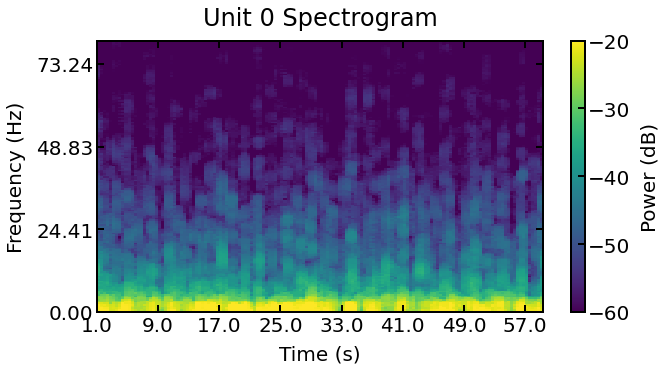

In [14]:
unit_num = 0
spec_limit = 80
spec_limit_ind = np.argmax(freq > spec_limit) if np.sum(freq > spec_limit) > 0 else len(freq)
plt.pcolormesh(10*np.log10(unit_specs[unit_num]))
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks([i for i in xticks if i < len(timepts)], [f"{timepts[int(i)]}" for i in xticks if i < len(timepts)])
yticks = ax.get_yticks()
plt.yticks([i for i in yticks if i < spec_limit_ind], [f"{freq[int(i)]:.2f}" for i in yticks if i < spec_limit_ind])
plt.clim([-60, -20])
plt.colorbar(label = 'Power (dB)')
plt.title(f"Unit {unit_num} Spectrogram")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [80]:
# KL Divergence with a log-spectral deviation
def kappa(G, H, df):
    G_tilde = G/np.sum(G)
    H_tilde = H/np.sum(H)
    return np.sum(G_tilde*np.log(G_tilde/H_tilde))
#     return (1 + np.sum(np.abs(np.log((G/H)))*df))*np.sum(G_tilde*np.log(G_tilde/H_tilde)*df)
#     return (1 + np.sum(np.abs(np.log((G/H)))*df))*np.sum((G_tilde - H_tilde)*np.log(G_tilde/H_tilde)*df)

def compute_divergence_fluctuation(spec, df):
    mean_spectrum = spec.mean(axis = 1)
    divergences = np.zeros(spec.shape[1])
    for t in range(spec.shape[1]):
        divergences[t] = kappa(spec[:, t], mean_spectrum, df)
    
    return np.std(divergences)**2

def test_surrogate_stationarity(signal, spec, dt, df, num_surrogates=30, verbose=False, return_debug=False):
    standard_divergence_fluctuation = compute_divergence_fluctuation(spec, df)
    surrogate_signals = surrogates(signal, num_surrogates, verbose=verbose)
    
    surrogate_specs = np.zeros((num_surrogates, spec.shape[0], spec.shape[1]))
    surrogate_divergence_fluctuation = np.zeros(num_surrogates)
    for i in tqdm(range(num_surrogates), disable=not verbose):
        surrogate_spec, freq, timepts = spectra.spectrogram(surrogate_signals[i], 1/dt, **spectrogram_kwargs)
        surrogate_specs[i] = surrogate_spec
        surrogate_divergence_fluctuation[i] = compute_divergence_fluctuation(surrogate_spec, df)
    
    _, p_value = scipy.stats.ttest_1samp(surrogate_divergence_fluctuation, standard_divergence_fluctuation, alternative='greater')
    
    if return_debug:
        return p_value, standard_divergence_fluctuation, surrogate_divergence_fluctuation, surrogate_specs, surrogate_signals
    else:
        return p_value, standard_divergence_fluctuation, surrogate_divergence_fluctuation

In [ ]:
num_surrogates = 50
verbose = False
df = freq[1] - freq[0]
p_values = np.zeros(big_signal.shape[1])
standard_flucts = np.zeros(big_signal.shape[1])
surrogate_flucts = np.zeros((big_signal.shape[1], num_surrogates))
for unit_num in tqdm(range(big_signal.shape[1])):
    p_values[unit_num], standard_flucts[unit_num], surrogate_flucts[unit_num] = test_surrogate_stationarity(big_signal[:, unit_num], unit_specs[unit_num], dt, df, num_surrogates=num_surrogates, verbose=verbose)
#     break

  0%|          | 0/64 [00:00<?, ?it/s]

In [127]:
# stationarity_temp = {'p_values': p_values, 'standard_flucts': standard_flucts, 'surrogate_flucts': surrogate_flucts}
# pd.to_pickle(stationarity_temp, '/om/user/eisenaj/stationarity_temp.pkl')

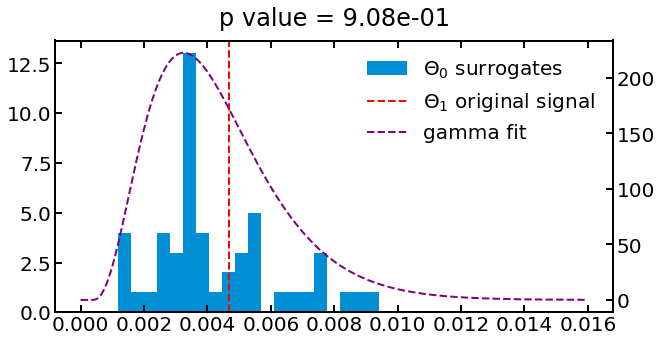

In [124]:
# unit_num = -1
# unit_num = 25
unit_num = -2
plt.hist(surrogate_flucts[unit_num], bins=20, label=r"$\Theta_0$ surrogates")
plt.axvline(standard_flucts[unit_num], c='r', linestyle='--', label=r"$\Theta_1$ original signal")
plt.title(f"p value = {p_values[unit_num]:.2e}")
# plt.legend()
ax = plt.gca()
ax2 = ax.twinx()
x = np.linspace(0, 0.016, 1000)
alpha_hat, loc_hat, beta_hat = scipy.stats.gamma.fit(surrogate_flucts[unit_num])
ax2.plot(x, scipy.stats.gamma(a=alpha_hat, loc=loc_hat, scale=beta_hat).pdf(x), c='purple', linestyle='--', label='gamma fit')
# ax2.legend()
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
plt.show()

In [107]:
plts

[<BarContainer object of 20 artists>,

In [56]:
# fig, axs = plt.subplots(5, 6, figsize=(35, 15))
# spec_limit = 80
# spec_limit_ind = np.argmax(freq > spec_limit) if np.sum(freq > spec_limit) > 0 else len(freq)
# for i in range(num_surrogates):
#     ax = axs[int(i/6)][i % 6]
#     quadmesh = ax.pcolormesh(10*np.log10(surrogate_specs[i]))
#     xticks = ax.get_xticks()
#     ax.set_xticks([i for i in xticks if i < len(timepts)], [f"{timepts[int(i)]}" for i in xticks if i < len(timepts)])
#     yticks = ax.get_yticks()
#     ax.set_yticks([i for i in yticks if i < spec_limit_ind], [f"{freq[int(i)]:.2f}" for i in yticks if i < spec_limit_ind])
#     quadmesh.set_clim([-60, -20])
#     plt.colorbar(quadmesh, label = 'Power (dB)', ax=ax)
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Frequency (Hz)')
# plt.tight_layout()
# plt.show()

In [55]:
# fig, axs = plt.subplots(5, 6, figsize=(35, 15))
# spec_limit = 80
# for i in range(num_surrogates):
#     ax = axs[int(i/6)][i % 6]
#     ax.plot(surrogate_signals[i])
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('mV')
# plt.tight_layout()
# plt.show()

In [58]:
# spec_limit = 80
# spec_limit_ind = np.argmax(freq > spec_limit) if np.sum(freq > spec_limit) > 0 else len(freq)
# plt.pcolormesh(10*np.log10(unit_specs[unit_num]))
# ax = plt.gca()
# xticks = ax.get_xticks()
# plt.xticks([i for i in xticks if i < len(timepts)], [f"{timepts[int(i)]}" for i in xticks if i < len(timepts)])
# yticks = ax.get_yticks()
# plt.yticks([i for i in yticks if i < spec_limit_ind], [f"{freq[int(i)]:.2f}" for i in yticks if i < spec_limit_ind])
# plt.clim([-60, -20])
# plt.colorbar(label = 'Power (dB)')
# plt.title(f"Unit {unit_num} Spectrogram")
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.show()

## Preprocessing

In [9]:
# the problem with this is that it is meant for only one dimension
def match_first_derivatives(x, K1=1000, K2=1000, p=100, verbose=False):
    L = len(x)
    k1_vals = np.arange(K1)
    k2_vals = np.arange(L - K2 - p, L - p)
    mismatches = np.zeros((len(k1_vals), len(k2_vals)))
    iterator = tqdm(total=len(k1_vals)*len(k2_vals), disable=not verbose)
    for i, k1 in enumerate(k1_vals):
        for j, k2 in enumerate(k2_vals):
            mismatches[i, j] = np.sum((x[k1:k1 + p + 1] - x[k2:k2 + p + 1])**2)
            iterator.update()
    iterator.close()
    
    k1_ind, k2_ind = np.unravel_index(np.argmin(mismatches), shape=mismatches.shape)
    k_start = k1_vals[k1_ind]
    k_end = k2_vals[k2_ind]
    
    return k_start, k_end

In [10]:
signal_in = np.zeros(big_signal.shape)
for i in tqdm(range(big_signal.shape[1])):
    signal = big_signal[:, i]
    # take out linear trend
    signal = scipy.signal.detrend(signal, type='linear')
    signal_in[:, i] = signal
    
# # match first derivatives and starting points
# k_start, k_end = match_first_derivatives(signal_in, K1=1000, K2=1000, p=100, verbose=True)
# signal_in = signal_in[k_start:k_end]

for i in tqdm(range(big_signal.shape[1])):
    signal = signal_in[:, i]
    # take out linear trend
    signal = scipy.signal.detrend(signal, type='linear')
    signal_in[:, i] = signal

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

# Generate Surrogates

In [14]:
signals = {}
signal_analysis = {}
signals['standard'] = signal_in.copy()
d = 10
indices = np.random.choice(signals['standard'].shape[1], size=(d, ), replace=False)

In [78]:
# ================
# IAAFT
# ================
if 'iaaft' not in signals.keys():
    print('Iterative AAFT')
    signals['iaaft'] = np.zeros(signals['standard'].shape)
    for i in tqdm(range(signals['standard'].shape[1])):
        signals['iaaft'][:, i] = surrogates(signals['standard'][:, i], 1, verbose=False)[0]
        
# ================
# WINDOWED IAAFT
# ================
iaaft_window = 2 # s
iaaft_window = int(iaaft_window/dt)
if 'windowed-iaaft' not in signals.keys():
    print('Windowed Iterative AAFT')
    signals['windowed-iaaft'] = np.zeros(signals['standard'].shape)
    num_windows = int(np.ceil(signals['standard'].shape[0]/iaaft_window))
    for i in tqdm(range(signals['standard'].shape[1])):
        for window_num in range(num_windows):
            start_ind = window_num*iaaft_window
            end_ind = int(np.min([(window_num + 1)*iaaft_window, signals['standard'].shape[0]]))
            signals['windowed-iaaft'][start_ind:end_ind, i] = surrogates(signals['standard'][start_ind:end_ind, i], 1, verbose=False)[0]

# ================
# SHUFFLED
# ================
if 'shuffled' not in signals.keys():
    print('Data Shuffling')
    signals['shuffled'] = np.zeros(signals['standard'].shape)
    for i in tqdm(range(signals['standard'].shape[1])):
        signals['shuffled'][:, i] = signals['standard'][np.random.permutation(np.arange(signals['standard'].shape[0])), i]

# ================
# LOPASS 100 Hz
# ================

if 'lowpass' not in signals.keys():
    print('Lowpass 100Hz')
    signals['lowpass'] = np.zeros(signals['standard'].shape)
    for i in tqdm(range(signals['standard'].shape[1])):
        signals['lowpass'][:, i] = butter_lowpass_filter(signals['standard'][:, i], 100, 1/dt, order=25)

# # ================
# # LOPASS 100 Hz Subsampled
# # ================

# if 'lowpass_sub' not in signals.keys():
#     print('Lowpass 100Hz Subsampled')
#     signals['lowpass_sub'] = signals['lowpass'][np.arange(0, signals['lowpass'].shape[0], 2)]

# ================
# BANDPASS 5 - 35 Hz
# ================
if 'bandpass' not in signals.keys():
    print('Bandpass 5Hz - 35Hz')
    signals['bandpass'] = np.zeros(signals['standard'].shape)
    for i in tqdm(range(signals['standard'].shape[1])):
        signals['bandpass'][:, i] = butter_bandpass_filter(signals['standard'][:, i], 5, 35, 1/dt, order=5)

Bandpass 5Hz - 35Hz


  0%|          | 0/64 [00:00<?, ?it/s]

In [73]:
# del signals['windowed-iaaft']
# del signal_analysis['windowed-iaaft']

### Pseudo-periodic Surrogates

# Plot Embeddings

## Single Channel

In [74]:
index = 0

In [75]:
def pick_tau(sig_in, nlags=500, bins=64, verbose=False):
    # pick tau
    delayed_mi = np.zeros(nlags + 1)

    n = len(sig_in)
    for tau_ in tqdm(range(nlags + 1), disable=not verbose):
        delayed_mi[tau_] = delay.mi(sig_in[tau_:], sig_in[:n - tau_], bins=bins)
    local_min_locs = scipy.signal.argrelextrema(delayed_mi, np.less)[0]
    tau = local_min_locs[0]
    
    return tau, delayed_mi

In [79]:
embedded = {}
for key, signal in signals.items():
    tau, delayed_mi = pick_tau(signal[:, index], verbose=True)
    embedded[key] = embed_signal(signal[:, index], 3, tau)

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

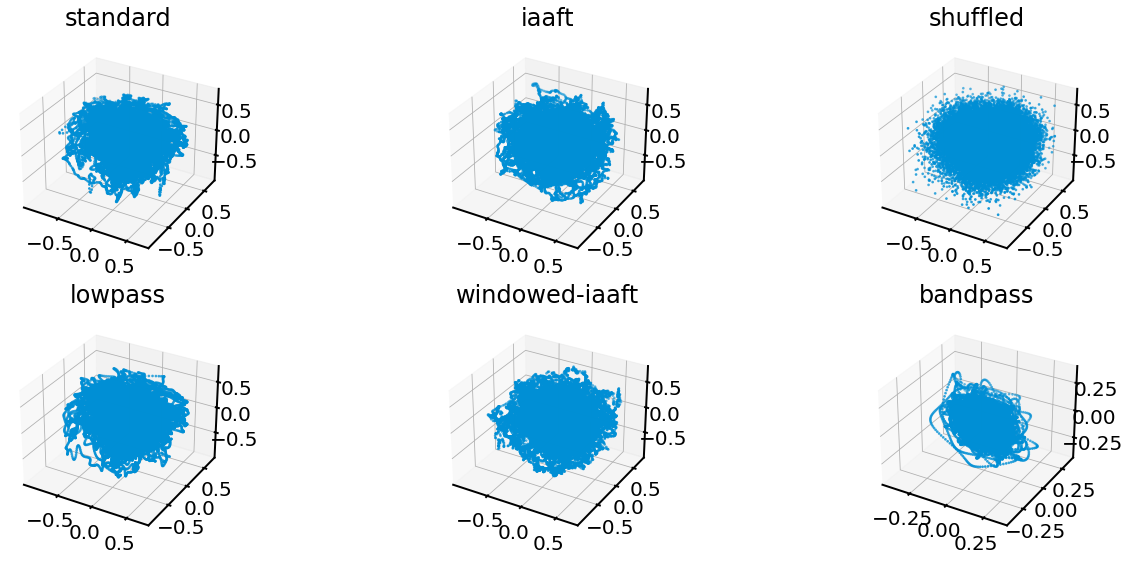

In [80]:
fig = plt.figure(figsize=(20, 8))
for i, (key, embedded_sig) in enumerate(embedded.items()):
    subplot_num = int(f"23{i + 1}")
    ax = fig.add_subplot(subplot_num, projection='3d')
    ax.scatter(embedded_sig[:, 0], embedded_sig[:, 1], embedded_sig[:, 2], s=3)
    ax.set_title(key)
plt.tight_layout()

# Plot Surrogates

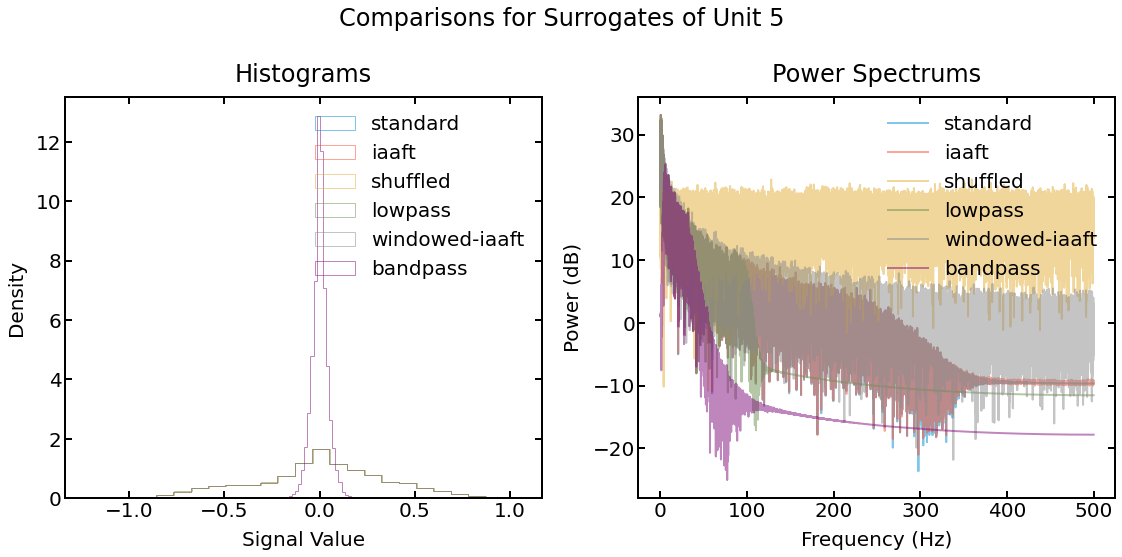

In [81]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
for key, signal in signals.items():
    plt.hist(signal[:, i], alpha=0.5, label=key, histtype=u'step', bins=25, density=True)
plt.ylabel('Density')
plt.xlabel('Signal Value')
plt.legend()
plt.title(f"Histograms")
plt.subplot(1, 2, 2)
for key, signal in signals.items():
    freqs = np.fft.fftfreq(signal.shape[0], d=dt)
    fft_vals = np.fft.fft(signal[:, index])
    plt.plot(freqs[1:int(len(freqs)/2)], 10*np.log10(np.abs(fft_vals[1:int(len(fft_vals)/2)])), alpha=0.5, label=key)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.legend()
plt.title(f"Power Spectrums")
fig.suptitle(f"Comparisons for Surrogates of Unit {area_indices[i]}")
plt.tight_layout()
plt.show()

## Linear Summary Measure

In [82]:
Q_stats = {}
for key, signal in signals.items():
    Q_stats[key] = acorr_ljungbox(signal[:, index], 15)

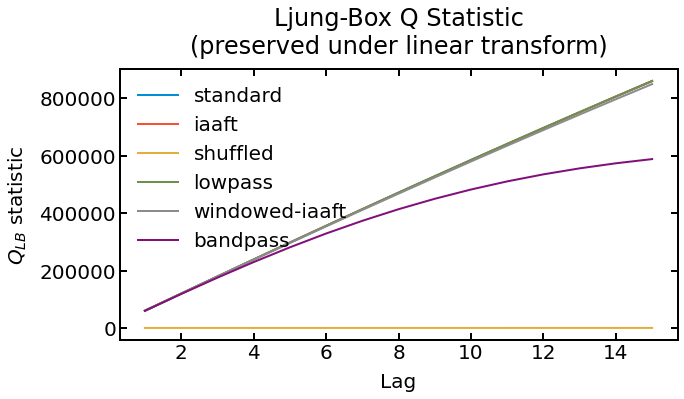

In [83]:
for i, (key, signal) in enumerate(signals.items()):
    plt.plot(np.arange(1, 16), Q_stats[key].lb_stat, label=key)
plt.xlabel('Lag')
plt.ylabel('$Q_{LB}$ statistic')
plt.title("Ljung-Box Q Statistic\n(preserved under linear transform)")
plt.legend()
plt.show()

## Nonlinear Summary Measure

In [151]:
from nolitsa import delay
from nolitsa.d2 import c2, c2_embed, d2, ttmle

In [162]:
r, c = c2(signal[:5000, :])

In [123]:
nlags = 500
bins = 64
max_m = 10
p = 2
r = 10

In [174]:
nld_results = {}



for key, signal in tqdm(signals.items()):
    print(key)
    
    end_step = signal.shape[0]
    
    r, c = c2(signal[:end_step, indices])
    lr = scipy.stats.linregress(np.log(r), np.log(c))
    
    slope, intercept = lr.slope, lr.intercept
    nld_results[key] = dict(
        r=r,
        c=c,
        slope=slope,
        interecept=intercept
    )
    
    
    # ============================
    # dimensional embedding
    # ============================
    
#     nld_results[key] = []
#     for i in tqdm([0, 1, 2]):
#         n = end_step
        ## pick tau
#         delayed_mi = np.zeros(nlags + 1)
#         for tau_ in range(nlags + 1):
#             delayed_mi[tau_] = delay.mi(signal[tau_:n, i], signal[:n - tau_, i], bins=bins)
#         local_min_locs = scipy.signal.argrelextrema(delayed_mi, np.less)[0]


#         tau = local_min_locs[0]

#         # pick m
#         m_vals = np.arange(1, max_m + 1)
#         fraction_fnn = np.zeros(m_vals.shape)

#         for i, m in enumerate(m_vals):
#             embedding = embed_signal(signal[:n, i], m, tau=tau)
#             nn_indices, _ = get_nn_indices(embedding, p=p)
#             fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
#             fraction_fnn[i] = fraction_greater

#         if sum(fraction_fnn < 0.1) > 0:
#             m = np.argmax(fraction_fnn < 0.1) + 1
#         else:
#             m = m_vals[-1]
        
#         c2_ret = c2_embed(signal[:n, i], dim=[m], tau=tau, r=100, metric='chebyshev')
#         r = c2_ret[0][:, 0]
#         c = c2_ret[0][:, 1]
        
#         d2_vals = d2(*c2_vals[0])
#         correlation_dim = ttmle(*c2_vals[0])

#         lr = scipy.stats.linregress(np.log(r), np.log(c))
    
#         slope, intercept = lr.slope, lr.intercept
    
        
#         nld_results[key].append(dict(
#             delayed_mi=delayed_mi,
#             tau=tau,
#             fraction_fnn=fraction_fnn,
#             m=m,
#             r=r,
#             c=c,
#             slope=slope,
#             intercept=intercept,
# #             c2=c2_vals,
# #             d2=d2_vals
#         ))

  0%|          | 0/6 [00:00<?, ?it/s]

standard
iaaft
shuffled
lowpass
windowed-iaaft
bandpass


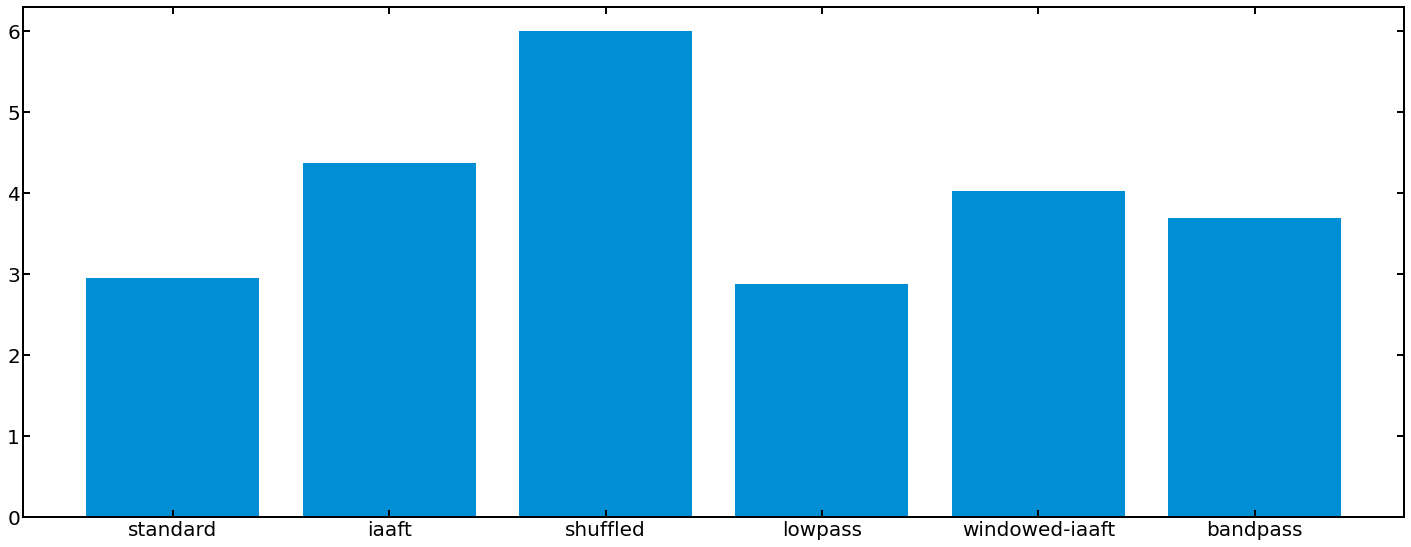

In [175]:
plt.figure(figsize=(20, 8))
plt.bar([key for key in nld_results.keys()], [nld_ret['slope'] for nld_ret in nld_results.values()])
plt.tight_layout()

In [166]:
# plt.plot(np.log(r), np.log(c))
# x = np.linspace(-10, -6.5)
# plt.plot(x, x*slope + intercept)

In [167]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# for key, nld_info in nld_results.items():
#     if key in ['standard', 'iaaft', 'windowed-iaaft']:
#         for i in range(3):
#             axs[i].plot(nld_info[i]['d2'], label=key)
# for i in range(3):
#     axs[i].legend()
#     axs[i].set_title(f'Unit {i}')
#     axs[i].set_xlabel('Distance')
#     axs[i].set_ylabel('Correlation Dimension')
# plt.show()


## Stationarity

In [91]:
# chunk_size = 2 # s
# chunk_size = int(chunk_size/dt)
# num_chunks = int(np.floor((signals['standard'].shape[0]-chunk_size)/chunk_size)+1)
# moments = np.zeros((num_chunks, 4))
# for i in range(num_chunks):
#     chunk = signals['standard'][i*chunk_size:(i + 1)*chunk_size, i]
#     moments[i, 0] = chunk.mean()
#     moments[i, 1] = scipy.stats.moment(chunk, moment=2)
#     moments[i, 2] = scipy.stats.moment(chunk, moment=3)
#     moments[i, 3] = scipy.stats.moment(chunk, moment=4)

# for i in range(4):
#     plt.plot(np.arange(moments.shape[0])*chunk_size*dt, moments[:, i], label=f"moment {i + 1} (stdev = {np.std(moments[:, i]):.3f})")
# plt.xlabel('Time (s)')
# plt.title("Moments of Standard Signal")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [92]:
# AIC = np.zeros(50)
# for p in range(50):
#     model = AutoReg(signals['standard'][:, i], p)
#     ret = model.fit()
#     AIC[p] = ret.aic
# plt.plot(AIC)
# model = AutoReg(signals['standard'][:, i], 15)
# ret = model.fit()
# het_arch(ret.resid, 15)

# Compute VAR(p) for Each Surrogate

In [93]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
# num_window_samples = 5
num_window_samples = 2

In [94]:
for key, signal in signals.items():
    if key not in signal_analysis.keys():
        print(f"now computing: {key}")
        data = signal[:, indices]
        VAR_results, grid_search_df, test_mse_mat, window, p = perform_VAR_p_analysis(data, windows, max_lag, T_pred=T_pred, num_window_samples=num_window_samples)
        signal_analysis[key] = dict(
            VAR_results=VAR_results,
            grid_search_df=grid_search_df,
            test_mse_mat=test_mse_mat,
            window=window,
            p=p
        )

now computing: windowed-iaaft


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

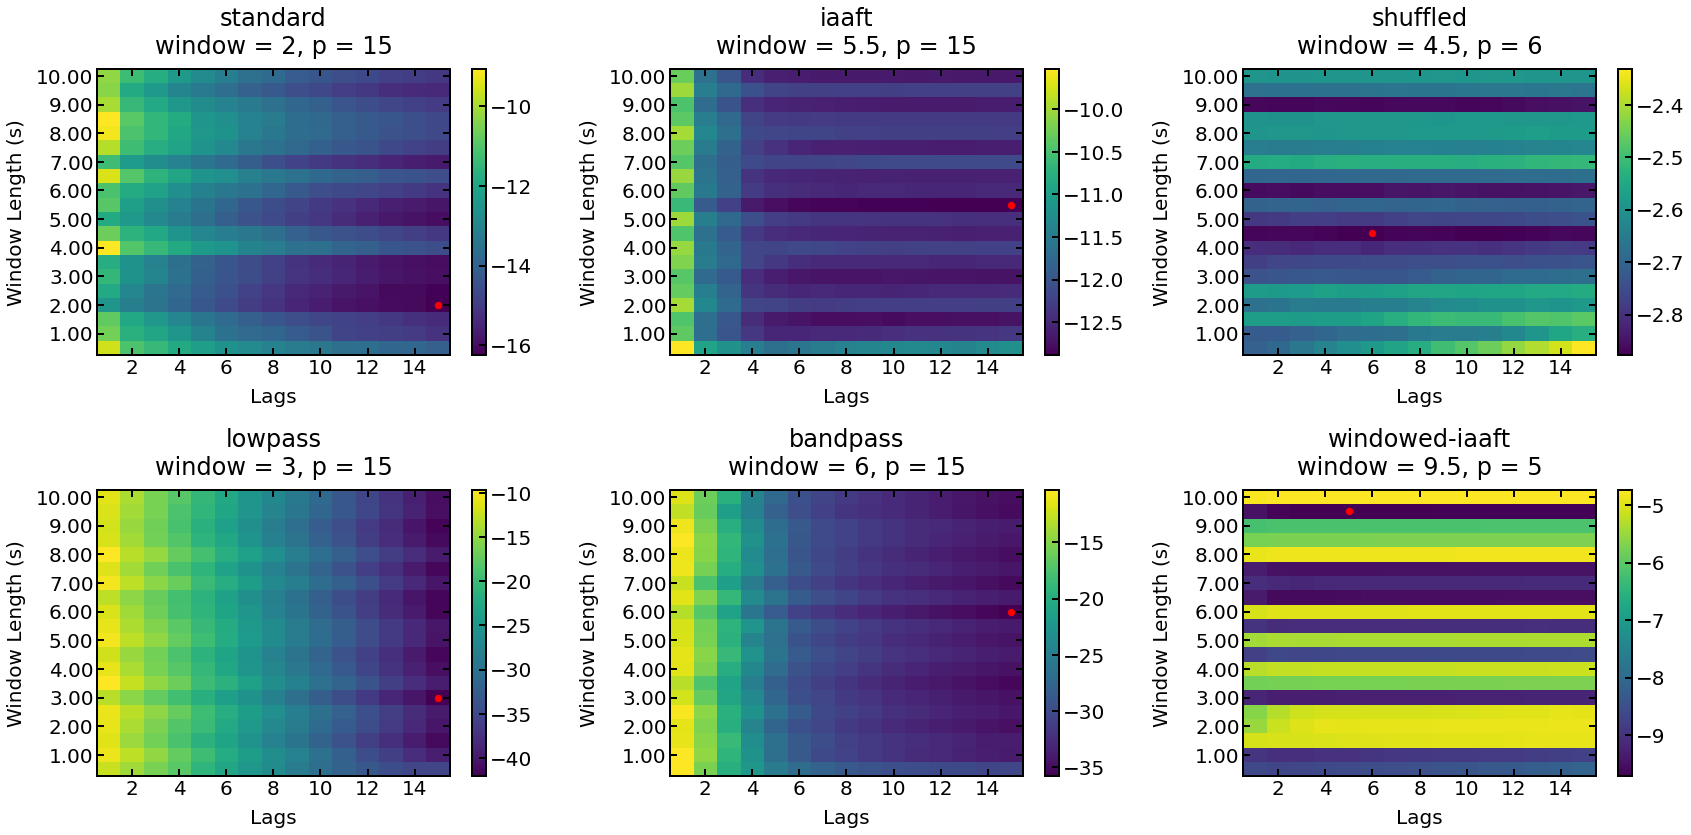

In [95]:
plt.style.use('../../sci_style.py')
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(np.arange(1, max_lag, 2) + 0.5)
    ax.set_xticklabels([lags[i] for i in np.arange(1, max_lag, 2)])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

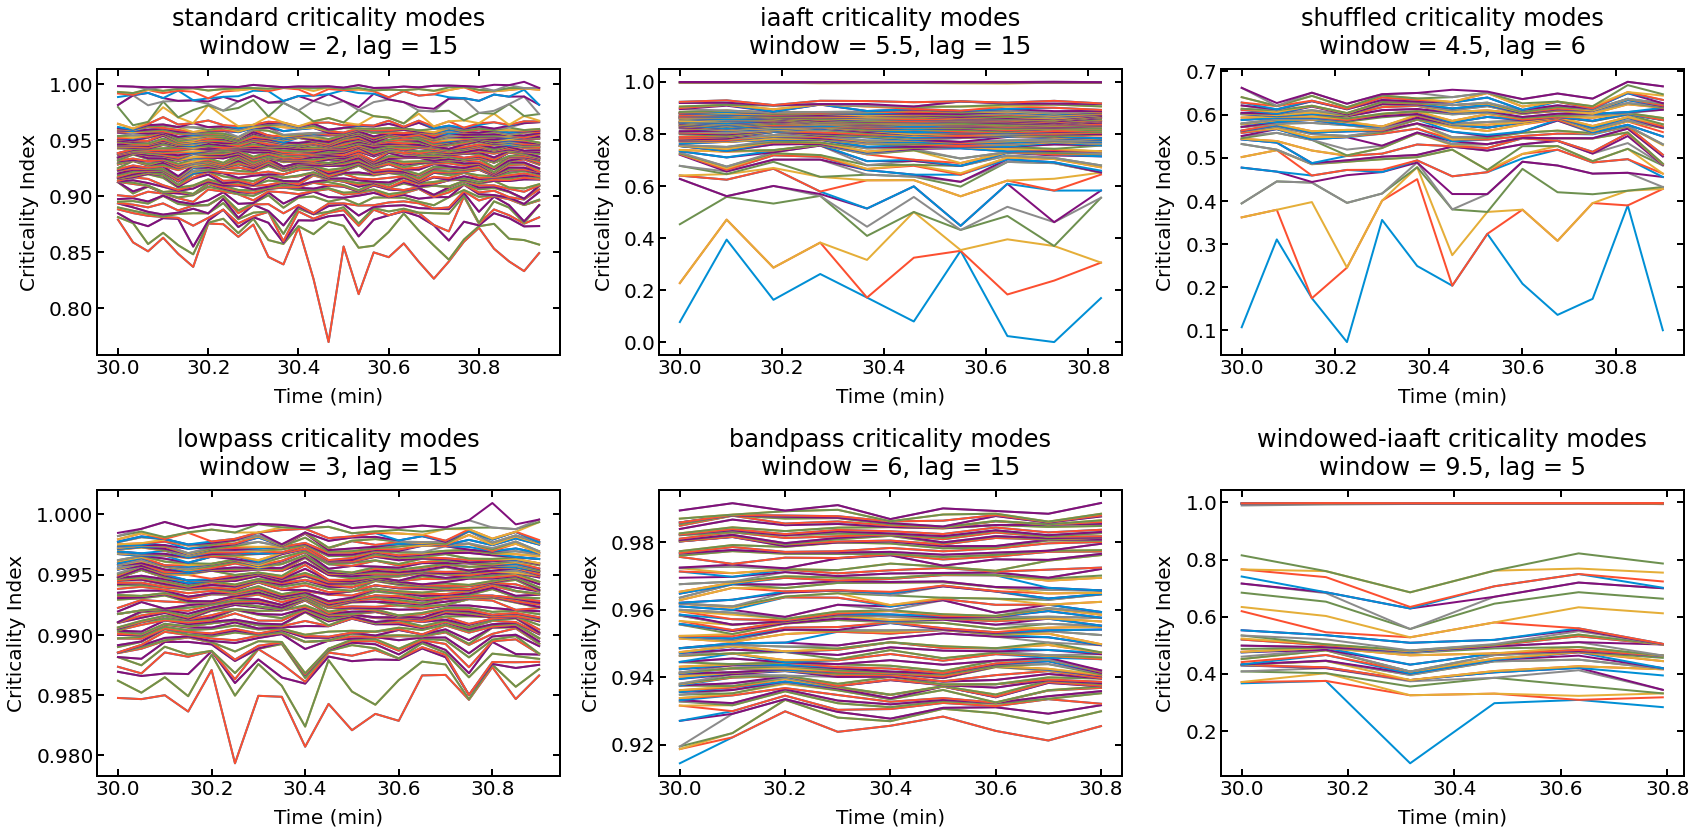

In [96]:
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    VAR_results = signal_info['VAR_results']
    mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
    for i, row in VAR_results.iterrows():
        mode_criticalities[i] = np.sort(row.criticality_inds)
    for i in range(len(VAR_results.criticality_inds.iloc[0])):
        ax.plot((VAR_results.start_time + big_window_start)/60, mode_criticalities[:, i])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} criticality modes\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

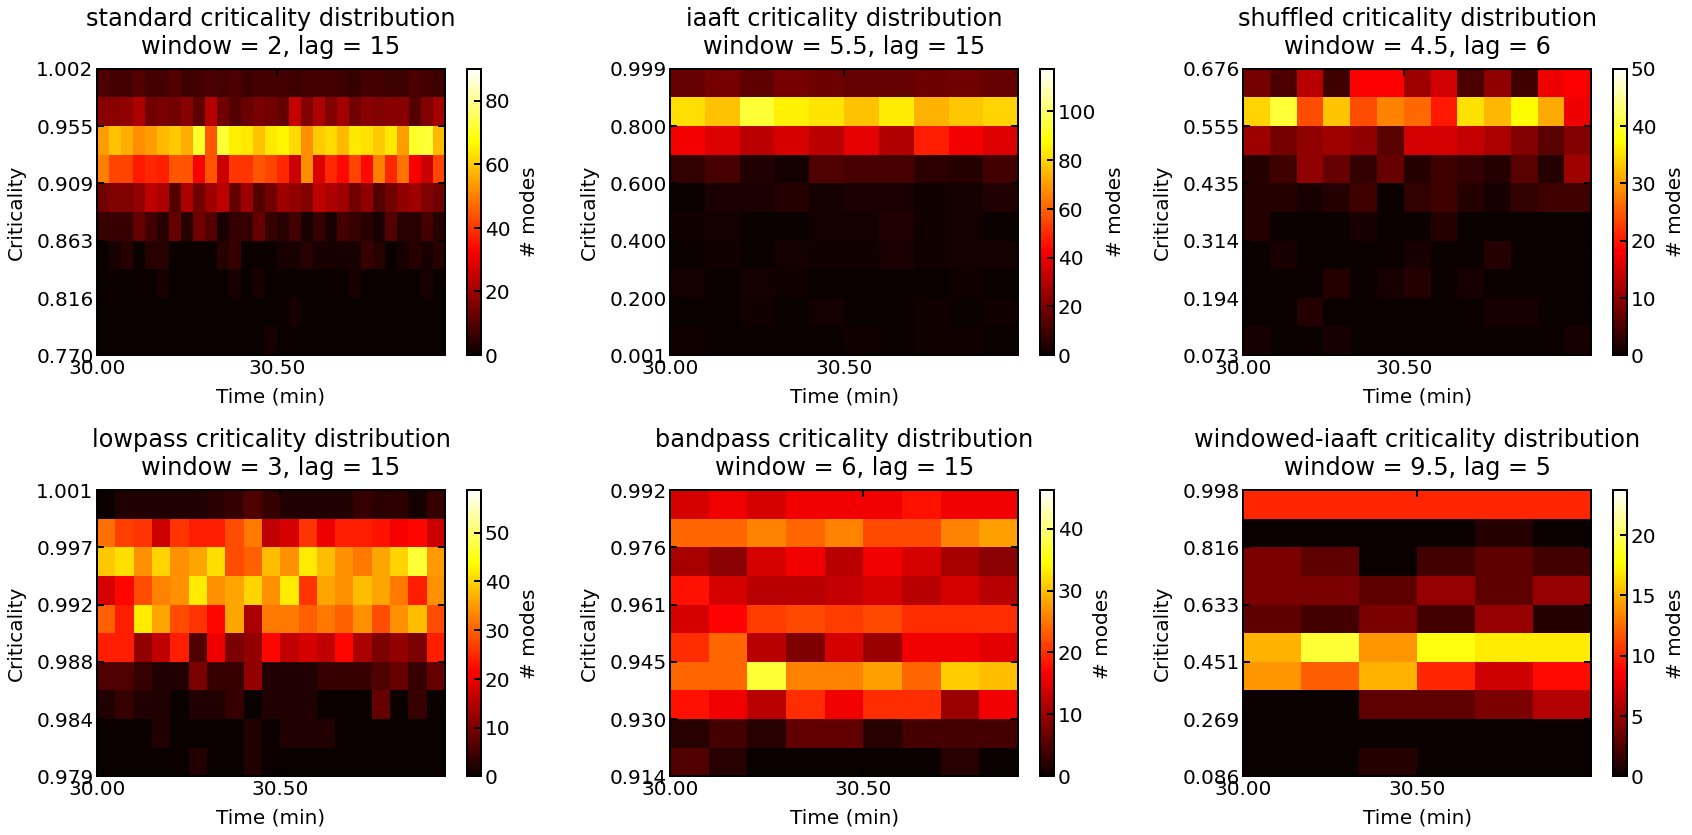

In [97]:
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    VAR_results = signal_info['VAR_results']
    
    stride = VAR_results.stride.iloc[0]
    bin_nums = 10
    bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
    bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results.criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
    start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
    T_max = VAR_results.criticality_inds.shape[0]*stride
    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
    ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 30)])
    ax.set_xticklabels([f"{(int(i) + big_window_start)/60:.2f}" for i in np.arange(0, T_max, 30)])
    ax.set_yticks(np.arange(0, bin_nums + 1, 2))
    ax.set_yticklabels([f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(label='# modes')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Criticality")
    ax.set_title(f"{key} criticality distribution\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

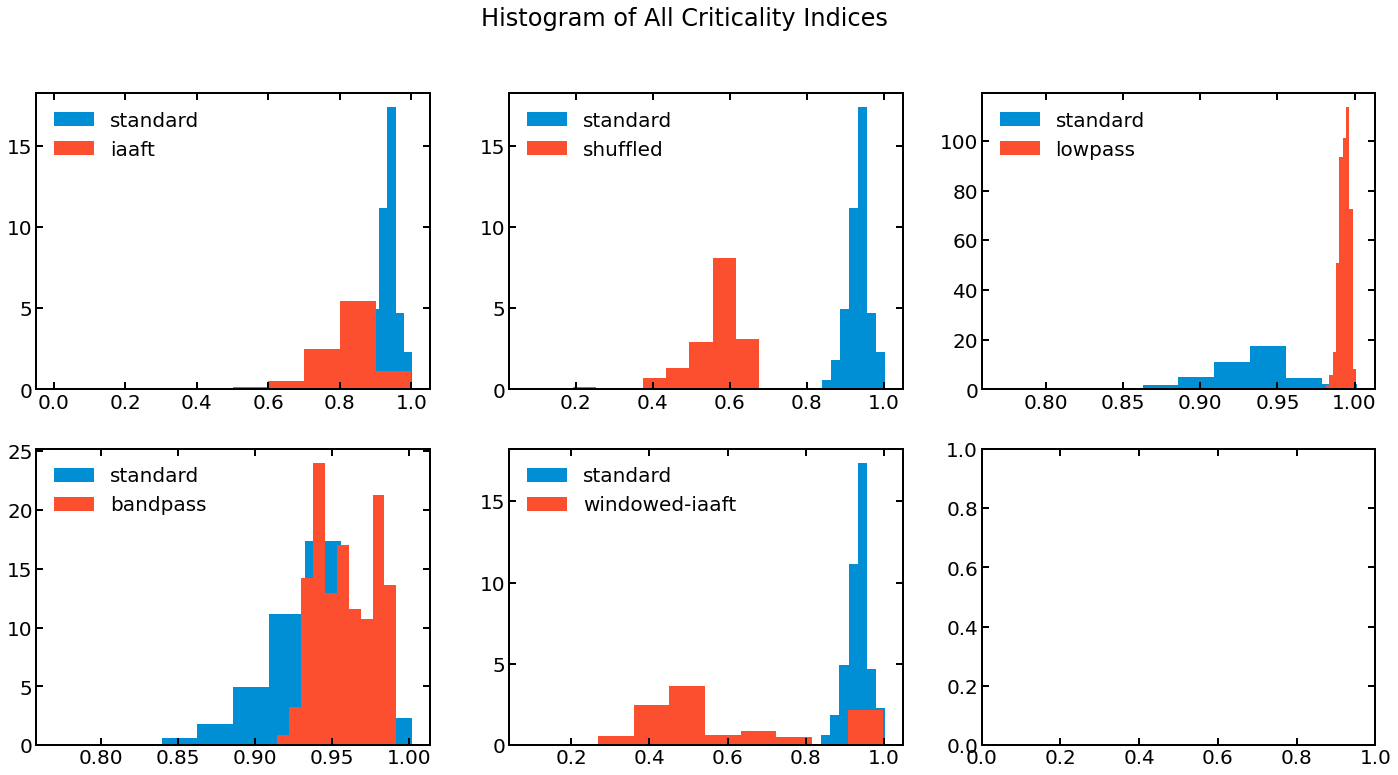

In [98]:
surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(surrogate_signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    all_surrogate_inds = np.hstack(signal_info['VAR_results'].criticality_inds)

    ax.hist(all_standard_inds, density=True, label='standard')
    ax.hist(all_surrogate_inds, density=True, label=key)
    ax.legend()
plt.suptitle('Histogram of All Criticality Indices')
plt.show()

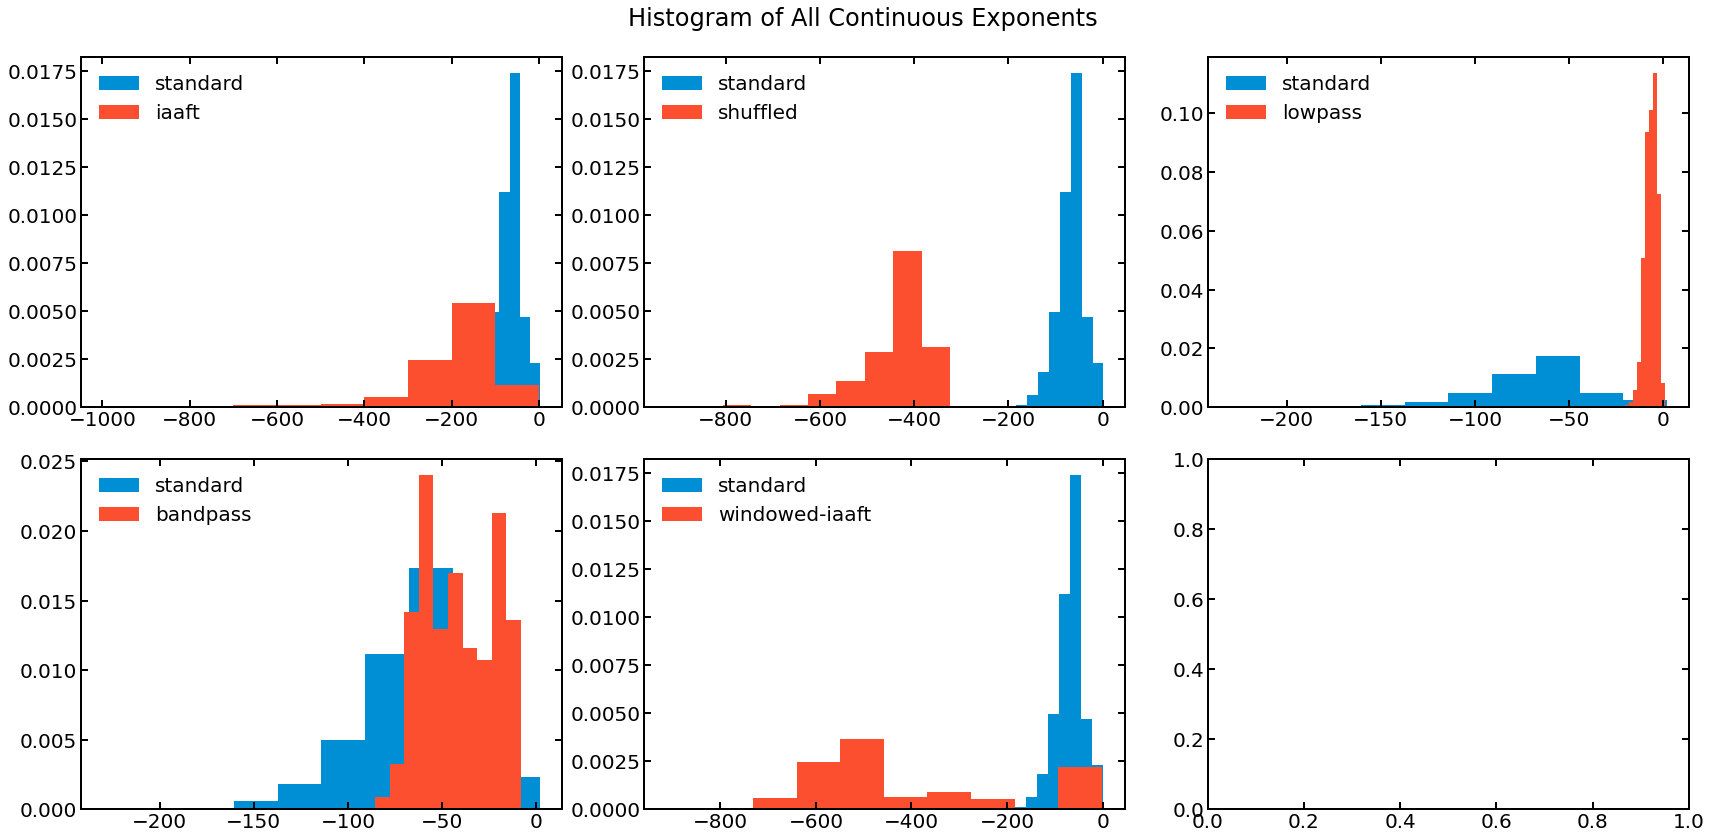

In [99]:
surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(surrogate_signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    all_surrogate_inds = np.hstack(signal_info['VAR_results'].criticality_inds)

    ax.hist((all_standard_inds - 1)/dt, density=True, label='standard')
    if key == 'lowpass_sub':
        ax.hist((all_surrogate_inds - 1)/0.002, density=True, label=key)
    else:
        ax.hist((all_surrogate_inds - 1)/dt, density=True, label=key)
    ax.legend()
plt.suptitle('Histogram of All Continuous Exponents')
plt.tight_layout()
plt.show()

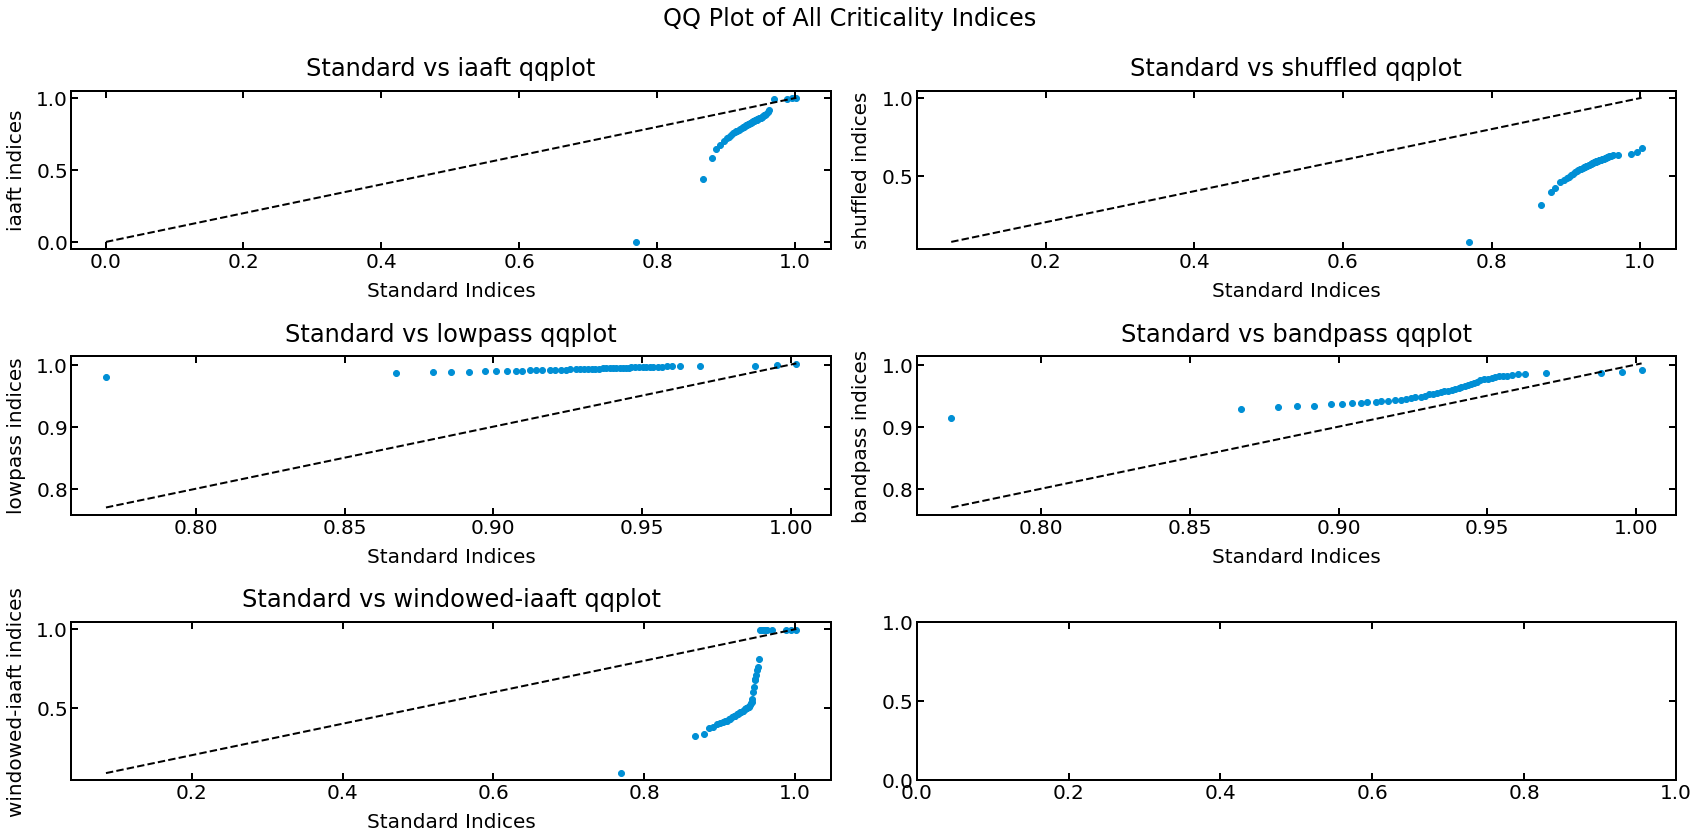

In [100]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(surrogate_signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    all_surrogate_inds = np.hstack(signal_info['VAR_results'].criticality_inds)

    qqplot(all_standard_inds, all_surrogate_inds, ax=ax, num_quantiles=50)
    ax.set_xlabel('Standard Indices')
    ax.set_ylabel(f"{key} indices")
    ax.set_title(f"Standard vs {key} qqplot")
plt.suptitle('QQ Plot of All Criticality Indices')
plt.tight_layout()
plt.show()

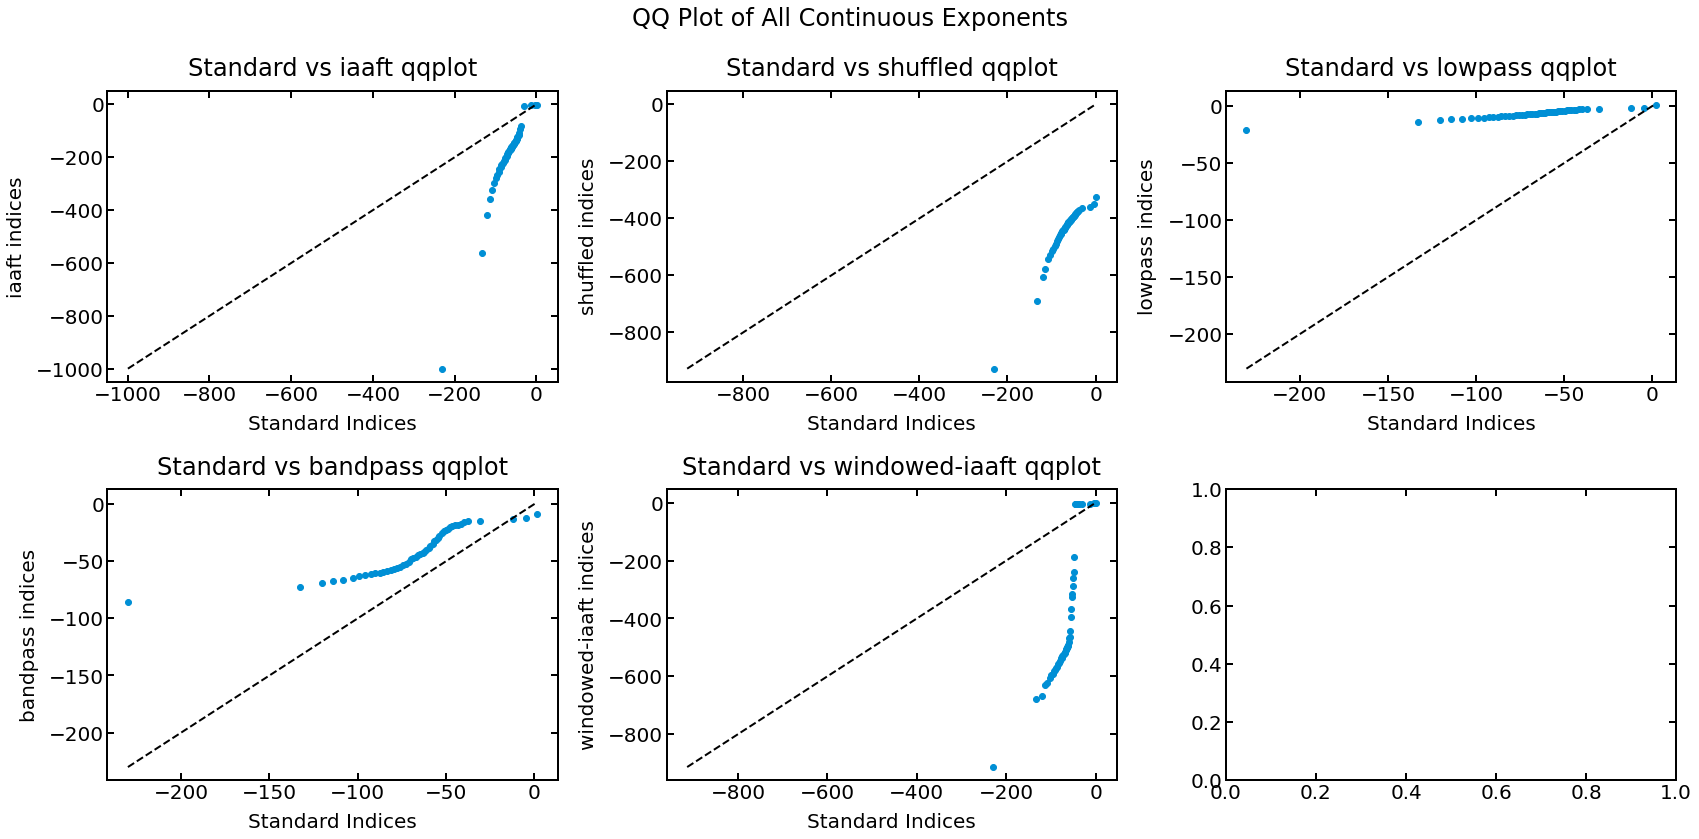

In [101]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(surrogate_signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    all_surrogate_inds = np.hstack(signal_info['VAR_results'].criticality_inds)

    if key == 'lowpass_sub':
        qqplot((all_standard_inds - 1)/dt, (all_surrogate_inds - 1)/0.002, ax=ax, num_quantiles=50)
    else:
        qqplot((all_standard_inds - 1)/dt, (all_surrogate_inds - 1)/dt, ax=ax, num_quantiles=50)
    ax.set_xlabel('Standard Indices')
    ax.set_ylabel(f"{key} indices")
    ax.set_title(f"Standard vs {key} qqplot")

# ax = axs[-1][-1]
# all_lowpass_inds = np.hstack(signal_analysis['lowpass']['VAR_results'].criticality_inds)
# all_lowpass_sub_inds = np.hstack(signal_analysis['lowpass_sub']['VAR_results'].criticality_inds)
# qqplot((all_lowpass_inds - 1)/dt, (all_lowpass_sub_inds - 1)/0.002, ax=ax)
# ax.set_xlabel('Lowpass Indices')
# ax.set_ylabel(f"Lowpass Subsampled indices")
# ax.set_title(f"Lowpass vs Lowpass Subsampled qqplot")

plt.suptitle('QQ Plot of All Continuous Exponents')
plt.tight_layout()
plt.show()

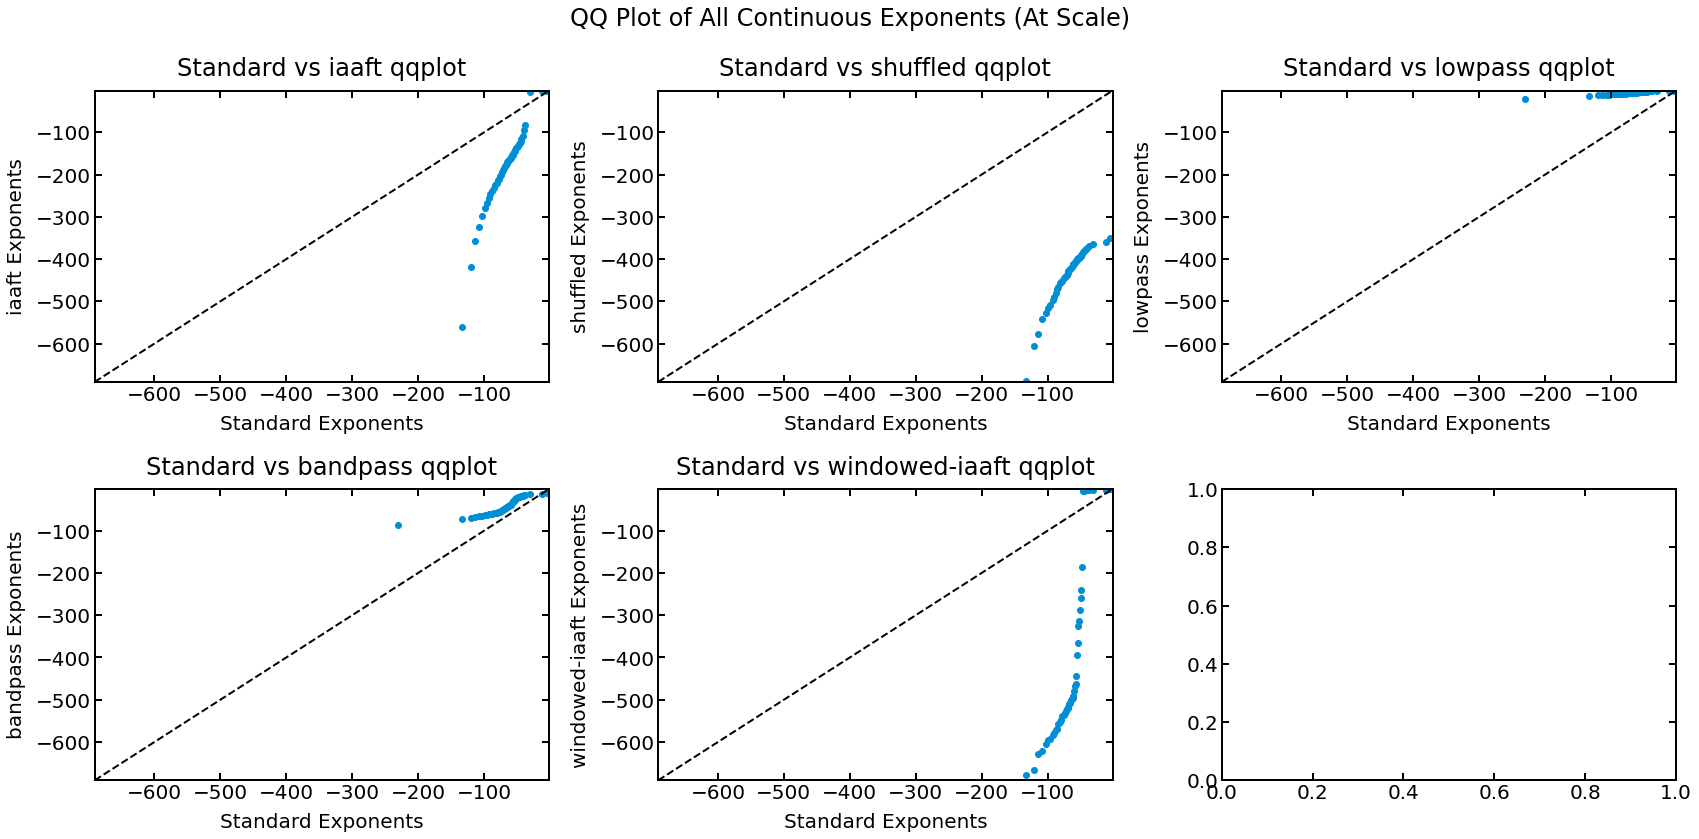

In [102]:
def qqplot(x, y, num_quantiles=None, ax=None, **kwargs):
 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if num_quantiles is None:
        num_quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    quantiles = np.linspace(0, 1, num_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)

    # Draw the q-q plot
    min_val = np.min([x_quantiles.min(), y_quantiles.min()])
    max_val = np.max([x_quantiles.max(), y_quantiles.max()])
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
#     ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), linestyle='--', c='k')

surrogate_signal_analysis = signal_analysis.copy()
del surrogate_signal_analysis['standard']
all_standard_inds = np.hstack(signal_analysis['standard']['VAR_results'].criticality_inds)

max_val = np.max([np.percentile(((np.hstack(signal_info['VAR_results'].criticality_inds) - 1)/dt), 98) for signal_info in signal_analysis.values()])
min_val = np.min([np.percentile(((np.hstack(signal_info['VAR_results'].criticality_inds) - 1)/dt), 2) for signal_info in signal_analysis.values()])

rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(24, 12))

for i, (key, signal_info) in enumerate(surrogate_signal_analysis.items()):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    all_surrogate_inds = np.hstack(signal_info['VAR_results'].criticality_inds)

    if key == 'lowpass_sub':
        qqplot((all_standard_inds - 1)/dt, (all_surrogate_inds - 1)/0.002, ax=ax, num_quantiles=50)
    else:
        qqplot((all_standard_inds - 1)/dt, (all_surrogate_inds - 1)/dt, ax=ax, num_quantiles=50)
    ax.set_xlabel('Standard Exponents')
    ax.set_ylabel(f"{key} Exponents")
    ax.set_title(f"Standard vs {key} qqplot")
    
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.plot(np.linspace(min_val, max_val, 1000), np.linspace(min_val, max_val, 1000), c='k', linestyle='--')

# ax = axs[-1][-1]
# all_lowpass_inds = np.hstack(signal_analysis['lowpass']['VAR_results'].criticality_inds)
# all_lowpass_sub_inds = np.hstack(signal_analysis['lowpass_sub']['VAR_results'].criticality_inds)
# qqplot((all_lowpass_inds - 1)/dt, (all_lowpass_sub_inds - 1)/0.002, ax=ax)
# ax.set_xlabel('Lowpass Indices')
# ax.set_ylabel(f"Lowpass Subsampled indices")
# ax.set_title(f"Lowpass vs Lowpass Subsampled qqplot")

plt.suptitle('QQ Plot of All Continuous Exponents (At Scale)')
plt.tight_layout()
plt.show()

# Residuals

In [41]:
model = VAR(big_signal[:10000])

In [42]:
VAR_results = model.fit(15)

In [64]:
all_resid = np.hstack([VAR_results.resid[:, i] for i in range(64)])
all_signal = np.hstack([big_signal[15:10000, i] for i in range(64)])

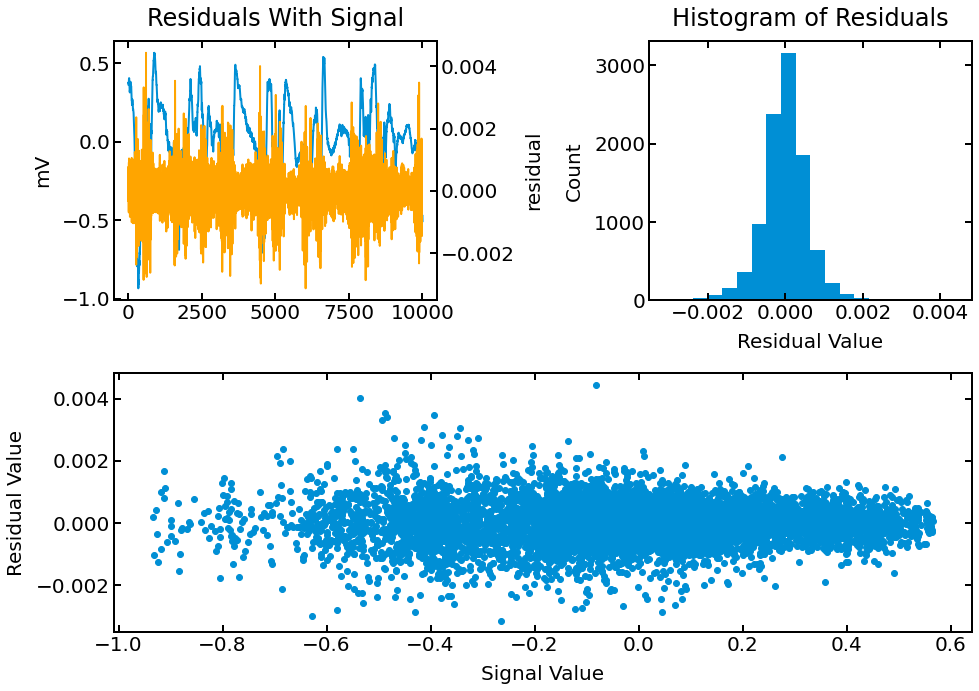

In [60]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(VAR_results.resid[:, 1], label='residuals', c='orange')
ax.plot(big_signal[:10000, 1], label='signal')
plt.xlabel("Time (ms)")
ax.set_ylabel('mV')
ax2.set_ylabel('residual')
plt.title('Residuals With Signal')
plt.subplot(2, 2, 2)
plt.hist(VAR_results.resid[:, 1], bins=20)
plt.title("Histogram of Residuals")
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.subplot(2, 1, 2)
plt.scatter(big_signal[15:10000, 1], VAR_results.resid[:, 1])
plt.xlabel('Signal Value')
plt.ylabel('Residual Value')
plt.tight_layout()
plt.show()

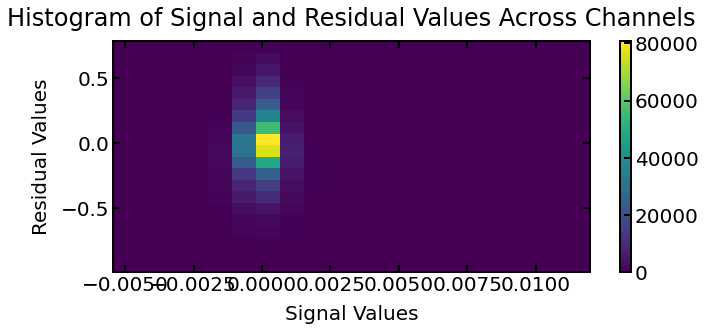

In [66]:
# plt.hist2d(big_signal[15:10000, 1], VAR_results.resid[:, 1], bins=20)
plt.hist2d(all_resid, all_signal, bins=20)
plt.colorbar()
plt.title("Histogram of Signal and Residual Values Across Channels")
plt.xlabel("Signal Values")
plt.ylabel("Residual Values")
plt.tight_layout()
plt.show()

# Constructing a Signal That Breaks VAR(p)

In [219]:
x[0] + delta_t*A @ x[0]

array([ 1.        , -1.97392088])

In [221]:
delta_t = 0.05
freq = 1 # Hz
omega0 = 2*np.pi*freq
zeta = 0
total_time = 10 # s
T = int(total_time/delta_t)
x = np.zeros((T, 2))
x[0] = (1, 0)
A = np.array([[0, 1], [-omega0**2, -2*zeta*omega0]])
for t in range(1, T):
    x[t] = x[t-1] + delta_t*(A @ x[t-1])

In [242]:
y = scipy.integrate.odeint(lambda y, t: delta_t*A @ y, (1, 0), np.arange(T))

In [223]:
np.linalg.eigvals(A)

array([0.+6.28318531j, 0.-6.28318531j])

In [224]:
np.abs(np.linalg.eigvals(np.eye(2) + delta_t*A))

array([1.04818703, 1.04818703])

In [225]:
(np.abs(np.linalg.eigvals(np.eye(2) + A)) - np.ones(2)), (np.abs(np.linalg.eigvals(np.eye(2) + delta_t*A)) - np.ones(2))/dt

(array([5.36226513, 5.36226513]), array([48.18702721, 48.18702721]))

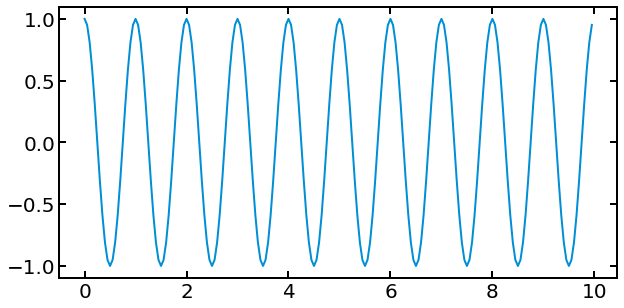

In [243]:
plt.plot(np.arange(y.shape[0])*delta_t, y[:, 0])
plt.show()

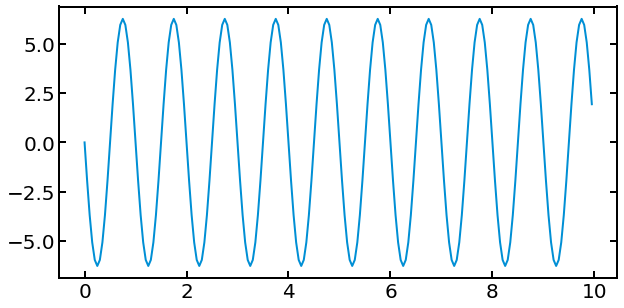

In [244]:
plt.plot(np.arange(y.shape[0])*delta_t, y[:, 1])

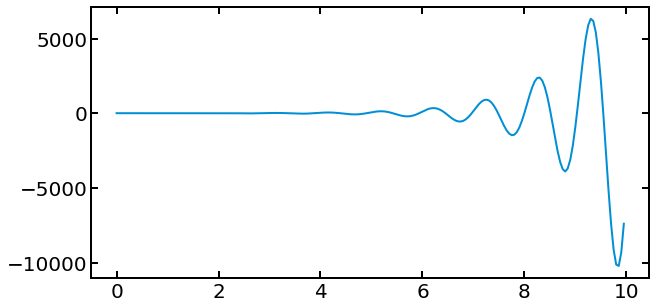

In [218]:
plt.plot(np.arange(x.shape[0])*delta_t, x[:, 0])